In [15]:
import pandas as pd
import numpy as np
from sklearn.decomposition import NMF
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from gensim.models import CoherenceModel
from gensim.corpora import Dictionary
from gensim.models.coherencemodel import CoherenceModel
from sklearn.metrics.pairwise import cosine_similarity

from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [2]:
recom_df = pd.read_pickle("data/recommendation_recipes.pkl")
recom_df

,name,ingredients,description,instructions,cuisine,course,diet,prep_time,categorized_prep_time,cleaned_ingredients,allergens,processed_name,processed_instructions,processed_description,allergen_type
0,Doddapatre Tambuli Recipe (Karpooravalli Thayi...,"4 cups Indian borage (Doddapatre) , cleaned an...",Doddapatre Tambuli Recipe is a popular healing...,"To begin making the Doddapatre Tambuli, first ...",Indian,Side Dish,Vegetarian,30.0,~30 min,"[indian borage doddapatre, curd dahi yogurt, c...",[yogurt],doddapatre tambuli karpooravalli thayir pachadi,doddapatre tambuli doddapatre leave dry towel ...,doddapatre tambuli popular healing cold yoghur...,[Dairy]
1,Fish Tandoori Recipe,"1 Fish , nicely washed with bones on (I used P...",Have you ever tried out fish tandoori? Trust m...,"To begin making the Fish Tandoori recipe, keep...",North Indian,Appetizer,High Protein Non Vegetarian,80.0,~1 hour 30 min,"[fish, curd dahi yogurt, onion, green chilli, ...",[fish],fish tandoori,fish tandoori head fin inside fish many horizo...,fish tandoori delicious chicken tandoori tando...,[Fish and Shellfish]
2,Arbi Shimla Mirch Sabzi Recipe – Colocasia Cap...,300 grams Colocasia root (Arbi) 1 Green Bell ...,Arbi Shimla Mirch Sabzi Recipe is a variation ...,To begin making the Arbi Shimla Mirch Sabzi Re...,North Indian,Main Course,No Onion No Garlic (Sattvic),55.0,~1 hour,"[colocasia root arbi, green bell pepper capsic...",[peanut],arbi shimla mirch sabzi colocasia capsicum sabzi,arbi shimla mirch sabzi arbi pressure pressure...,arbi shimla mirch sabzi variation aloo capsicu...,"[Tree Nuts and Peanuts, Legumes and Seeds]"
3,Ambur Style Brinjal Curry Recipe,5 Brinjal (Baingan / Eggplant) 1 Onion 2 Tom...,Brinjal Curry is prepared in different ways in...,To begin making the Ambur Style Brinjal Curry ...,Indian,Lunch,Vegetarian,20.0,~30 min,"[brinjal baingan eggplant, onion, ginger garli...","[sesame, mustard, peanut]",ambur style brinjal curry,ambur style brinjal curry oil heavy bottomed o...,brinjal curry different way different region s...,"[Legumes and Seeds, Tree Nuts and Peanuts]"
4,Mavinakayi Menasinakai Curry Recipe - Raw Man...,"1 cup Mango (Raw) , diced 2 tablespoons Jagge...",Mangalorean Mavinakayi Menasinakai Curry Recip...,To begin making Mangalorean Mavinakayi Menasin...,Mangalorean,Side Dish,Vegetarian,35.0,~45 min,"[mango, jaggery, turmeric powder, tamarind wat...",[sesame],mavinakayi menasinakai curry raw mango coconut...,mangalorean mavinakayi menasinakai curry raw m...,mangalorean mavinakayi menasinakai curry raw m...,[Legumes and Seeds]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9491,Spinach Oats Vada Recipe,"Spinach Leaves (Palak), Chana dal (Bengal Gram...",Spinach Oats Vada Recipe is a healthy twist to...,"To prepare Spinach Oats Vada Recipe, in a larg...",South Indian,Snack,Vegetarian,50.0,~1 hour,"[spinach palak, chana dal bengal gram dal, ins...",[oats],spinach oats vada,spinach oats vada large mixing ingredient vada...,spinach oats vada healthy twist vada superfood...,[Grains and Gluten]
9492,Kerala Style Vettu Cake Recipe (Eggless Wholew...,"Whole Wheat Flour, Sugar, Cooking soda, Butter...",Vettu cake is a famous tea shop snack in Tamil...,To prepare Kerala Style Vettu Cake Recipe (Egg...,Kerala,Snack,Vegetarian,65.0,~1 hour 15 min,"[whole wheat flour, sugar, soda, butter, salt,...","[wheat, egg, milk, butter]",kerala style vettu cake eggless wholewheat tea...,kerala style vettu cake eggless wholewheat tea...,vettu cake famous tea shop snack tamil nadu ke...,"[Grains and Gluten, Eggs, Dairy]"
9493,Amla/Nellikai Thogayal Recipe (Gooseberry Chut...,"Amla (Nellikai/ Gooseberry), Fresh coconut, Me...",The Gooseberry (Amla/Nellikai) Chutney recipe ...,"To begin making the Amla Thogayal, we will fir...",South Indian,Side Dish,Vegetarian,25.0,~30 min,"[amla nellikai gooseberry, fresh coconut, meth...",unknown,amla nellikai thogayal gooseberry chutney,amla thogayal gooseberry portion gooseberry cl...,gooseberr

In [3]:
recom_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9496 entries, 0 to 9495
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   name                    9496 non-null   object 
 1   ingredients             9496 non-null   object 
 2   description             9496 non-null   object 
 3   instructions            9496 non-null   object 
 4   cuisine                 9488 non-null   object 
 5   course                  9462 non-null   object 
 6   diet                    9462 non-null   object 
 7   prep_time               9487 non-null   float64
 8   categorized_prep_time   9496 non-null   object 
 9   cleaned_ingredients     9496 non-null   object 
 10  allergens               9496 non-null   object 
 11  processed_name          9496 non-null   object 
 12  processed_instructions  9496 non-null   object 
 13  processed_description   9496 non-null   object 
 14  allergen_type           9496 non-null   

In [4]:
# Convert each list in the 'cleaned_ingredient' column to a space-separated string to standardize the form of all precocessed colmuns. 
recom_df["processed_ingredients"] = recom_df['cleaned_ingredients'].apply(lambda x: ' '.join(x) if isinstance(x, list) else x)

# Combine all processed columns into a single column for topic modeling
recom_df['combined_context'] = recom_df['processed_name'] + ' ' + recom_df['processed_ingredients'] + ' ' + recom_df['processed_description'] + ' ' + recom_df['processed_instructions']
recom_df['combined_context']

0       doddapatre tambuli karpooravalli thayir pachad...
1       fish tandoori fish curd dahi yogurt onion gree...
2       arbi shimla mirch sabzi colocasia capsicum sab...
3       ambur style brinjal curry brinjal baingan eggp...
4       mavinakayi menasinakai curry raw mango coconut...
                              ...                        
9491    spinach oats vada spinach palak chana dal beng...
9492    kerala style vettu cake eggless wholewheat tea...
9493    amla nellikai thogayal gooseberry chutney amla...
9494    kanchakalar khosha bata traditional bengali ra...
9495    tomato onion chutney coconut mint onion green ...
Name: combined_context, Length: 9496, dtype: object

Train NMF model on TF-IDF and Count Vectorizer and find the best number of topics using coherence scores 

In [5]:

def compute_coherence_scores_nmf(texts, vectorizer, num_topics_range):
    coherence_scores = []
    tfidf_matrix = vectorizer.fit_transform(texts)
    
    # Tokenize each text in texts for Gensim's coherence calculation
    tokenized_texts = [text.split() for text in texts]
    dictionary = Dictionary(tokenized_texts)
    corpus = [dictionary.doc2bow(text) for text in tokenized_texts]
    
    # Iterate over each specified topic count
    for num_topics in num_topics_range:
        nmf_model = NMF(n_components=num_topics, random_state=42)
        topic_matrix = nmf_model.fit_transform(tfidf_matrix)
        
        # Extract top words for each topic and format as list of tokens
        feature_names = vectorizer.get_feature_names_out()
        topics = [[feature_names[i] for i in topic.argsort()[:-11:-1]] for topic in nmf_model.components_]
        
        tokenized_topics = [[word for word in topic] for topic in topics]# Coherence model requires a list of tokenized topics

        coherence_model = CoherenceModel(
            topics=tokenized_topics, 
            texts=tokenized_texts, 
            dictionary=dictionary, 
            coherence='c_v'
        )
        coherence_score = coherence_model.get_coherence()
        coherence_scores.append(coherence_score)
        
        print(f"Number of Topics: {num_topics}, Coherence Score: {coherence_score}")

    plt.figure(figsize=(10, 6))
    plt.plot(num_topics_range, coherence_scores, marker='o', linestyle='-', color='b')
    plt.xlabel("Number of Topics")
    plt.ylabel("Coherence Score")
    plt.title("Coherence Scores by Number of Topics")
    plt.show()


    best_num_topics = num_topics_range[coherence_scores.index(max(coherence_scores))]
    print(f"Best Number of Topics: {best_num_topics} with Coherence Score: {max(coherence_scores)}")
    
    return coherence_scores

Compare the performance of NMF model on TF-IDF vectorizer using "combined_context" and "name" columns seperately

Number of Topics: 1, Coherence Score: 0.5602083301818224
Number of Topics: 2, Coherence Score: 0.586356766371106
Number of Topics: 3, Coherence Score: 0.6089406030916802
Number of Topics: 4, Coherence Score: 0.6194650753927143
Number of Topics: 5, Coherence Score: 0.640758629489949
Number of Topics: 6, Coherence Score: 0.657684301300112
Number of Topics: 7, Coherence Score: 0.6464047393433253
Number of Topics: 8, Coherence Score: 0.6367068686790953
Number of Topics: 9, Coherence Score: 0.6561971018207651


c:\Users\rogha\anaconda3\envs\Tasty_AI\lib\site-packages\sklearn\decomposition\_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


Number of Topics: 10, Coherence Score: 0.6520468136156785
Number of Topics: 11, Coherence Score: 0.6563614959411783


c:\Users\rogha\anaconda3\envs\Tasty_AI\lib\site-packages\sklearn\decomposition\_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


Number of Topics: 12, Coherence Score: 0.6458630180954438
Number of Topics: 13, Coherence Score: 0.6442338965768852


c:\Users\rogha\anaconda3\envs\Tasty_AI\lib\site-packages\sklearn\decomposition\_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


Number of Topics: 14, Coherence Score: 0.6359081237449237
Number of Topics: 15, Coherence Score: 0.6454019627503457
Number of Topics: 16, Coherence Score: 0.6319119286036047
Number of Topics: 17, Coherence Score: 0.6349691242618608


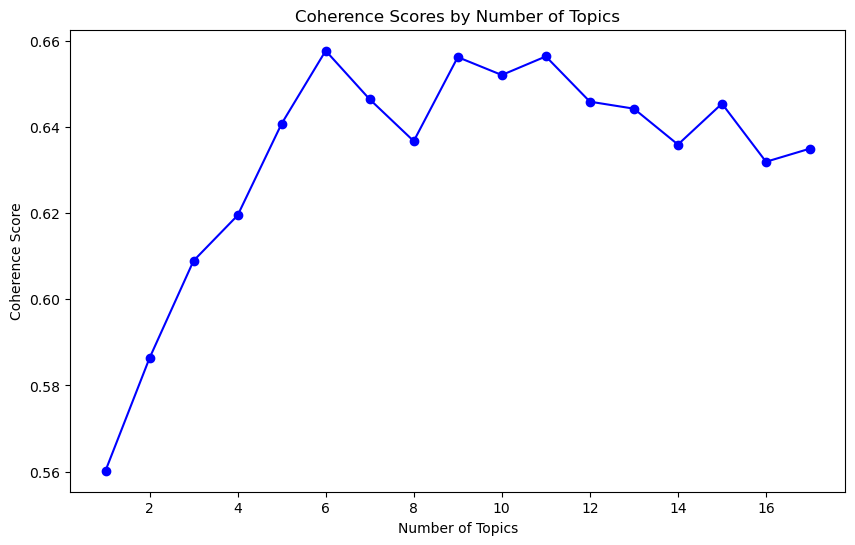

Best Number of Topics: 6 with Coherence Score: 0.657684301300112


In [6]:
combined_coherence_scores_nmf_tfidf = compute_coherence_scores_nmf(recom_df['combined_context'], TfidfVectorizer(), range(1, 18,1))

Number of Topics: 1, Coherence Score: 0.2872691998341319
Number of Topics: 2, Coherence Score: 0.3590390502531612
Number of Topics: 3, Coherence Score: 0.39400529564033865


c:\Users\rogha\anaconda3\envs\Tasty_AI\lib\site-packages\sklearn\decomposition\_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


Number of Topics: 4, Coherence Score: 0.3528077810414657
Number of Topics: 5, Coherence Score: 0.35372339451325585
Number of Topics: 6, Coherence Score: 0.37733202060613036
Number of Topics: 7, Coherence Score: 0.3635066753472205
Number of Topics: 8, Coherence Score: 0.4049985898234273
Number of Topics: 9, Coherence Score: 0.381825328323548
Number of Topics: 10, Coherence Score: 0.3910233163155471


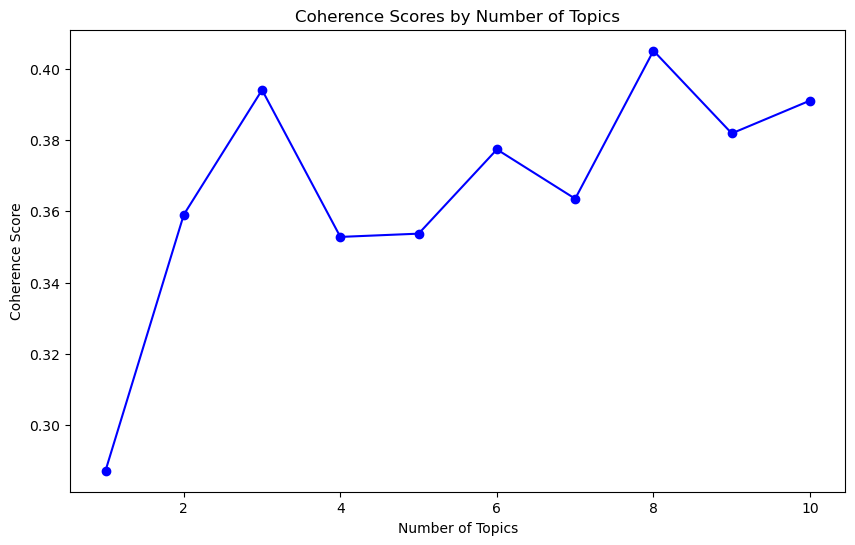

Best Number of Topics: 8 with Coherence Score: 0.4049985898234273


In [7]:
name_coherence_scores_nmf_tfidf = compute_coherence_scores_nmf(recom_df['processed_name'], TfidfVectorizer(), range(1, 11, 1))

Compare the performance of NMF model on Count vectorizer using "combined_context" and "name" columns seperately

Number of Topics: 1, Coherence Score: 0.6075562077810124
Number of Topics: 2, Coherence Score: 0.6459687746725788
Number of Topics: 3, Coherence Score: 0.5902706186604902
Number of Topics: 4, Coherence Score: 0.5899771333032021
Number of Topics: 5, Coherence Score: 0.5638613921372759
Number of Topics: 6, Coherence Score: 0.5957854997360742
Number of Topics: 7, Coherence Score: 0.5812766247387229
Number of Topics: 8, Coherence Score: 0.5827003920707559
Number of Topics: 9, Coherence Score: 0.5912075497948399
Number of Topics: 10, Coherence Score: 0.5941577269994601


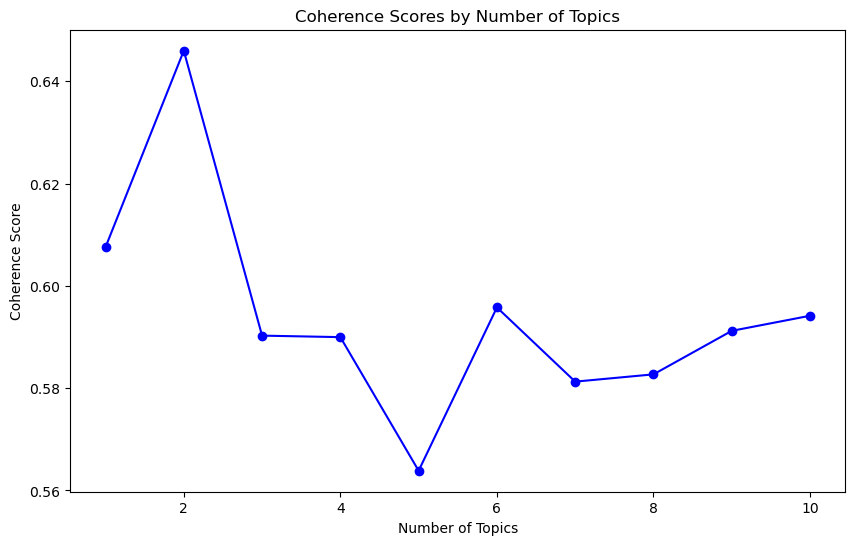

Best Number of Topics: 2 with Coherence Score: 0.6459687746725788


In [10]:
combined_coherence_scores_nmf_countvect = compute_coherence_scores_nmf(recom_df['combined_context'],  CountVectorizer(), range(1, 11, 1))

Number of Topics: 15, Coherence Score: 0.3632625577290341
Number of Topics: 16, Coherence Score: 0.3988508078560684
Number of Topics: 17, Coherence Score: 0.3914812650141221
Number of Topics: 18, Coherence Score: 0.40739809171320773
Number of Topics: 19, Coherence Score: 0.40483608860125925
Number of Topics: 20, Coherence Score: 0.3955352392211415
Number of Topics: 21, Coherence Score: 0.39858491400115365
Number of Topics: 22, Coherence Score: 0.39325641665148386
Number of Topics: 23, Coherence Score: 0.4067332915269558
Number of Topics: 24, Coherence Score: 0.4157865542399403
Number of Topics: 25, Coherence Score: 0.41103903567978234
Number of Topics: 26, Coherence Score: 0.41111983829446747
Number of Topics: 27, Coherence Score: 0.40760293296319394
Number of Topics: 28, Coherence Score: 0.4068662220181093
Number of Topics: 29, Coherence Score: 0.40267163017986424


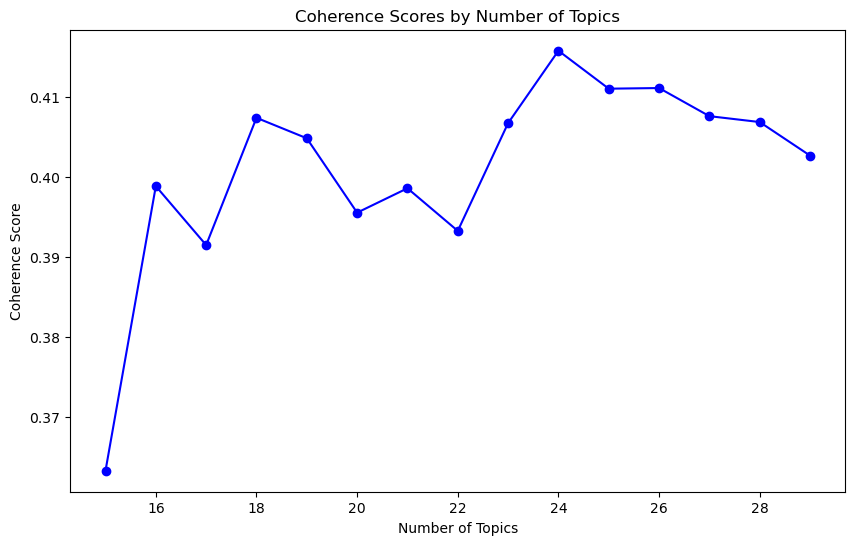

Best Number of Topics: 24 with Coherence Score: 0.4157865542399403


In [11]:
name_coherence_scores_nmf_countvect = compute_coherence_scores_nmf(recom_df['processed_name'],  CountVectorizer(), range(15, 30,1))

Choose the model with the highest coherence score for more exploration

Display the top words for each topic

In [12]:
best_num_topics = 6
tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(recom_df['combined_context'])

# Train NMF model with the optimal number of topics
nmf_model = NMF(n_components=best_num_topics, random_state=42)
nmf_model.fit(tfidf_matrix)

# Get the feature names (vocabulary) from the vectorizer
feature_names = tfidf_vectorizer.get_feature_names_out()

num_top_words = 10  
for topic_idx, topic in enumerate(nmf_model.components_):
    top_words = [feature_names[i] for i in topic.argsort()[:-num_top_words - 1:-1]]
    print(f"Topic {topic_idx + 1}: {' '.join(top_words)}")

Topic 1: powder masala onion potato coriander chilli curry seed sabzi turmeric
Topic 2: chicken garlic piece powder onion paste breast ginger murgh chilli
Topic 3: dough paratha flour wheat portion paneer ball roti circle side
Topic 4: dal moong urad pressure chutney dosa chana mustard curry coconut
Topic 5: pasta pepper sauce cheese mushroom vegetable olive spinach salad corn
Topic 6: milk cake sugar rice chocolate batter almond banana halwa cardamom


Plot the topic distribution

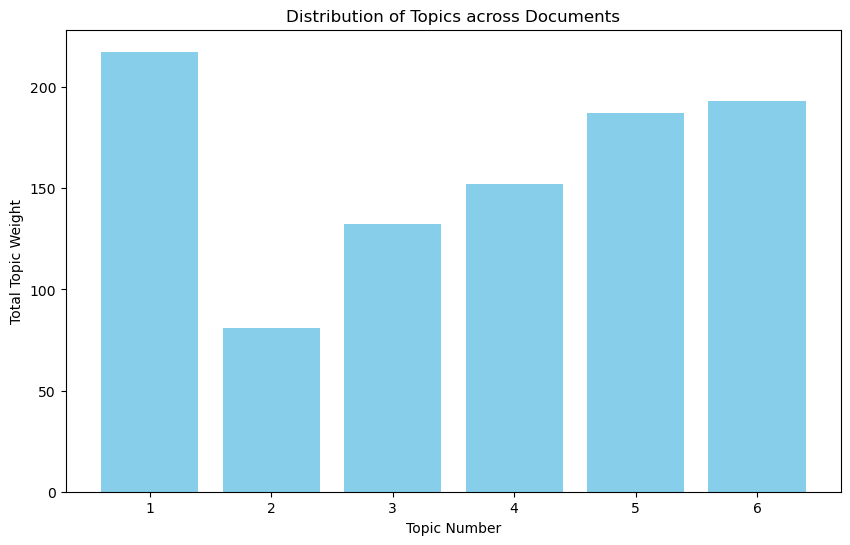

In [23]:
best_num_topics = 6
tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(recom_df['combined_context'])

# Train the NMF model with the optimal number of topics
nmf_model = NMF(n_components=best_num_topics, random_state=42)
topic_matrix = nmf_model.fit_transform(tfidf_matrix)

# Sum the topic weights across all documents for each topic
topic_distribution = np.sum(topic_matrix, axis=0)

plt.figure(figsize=(10, 6))
plt.bar(range(1, best_num_topics + 1), topic_distribution, color='skyblue')
plt.xlabel("Topic Number")
plt.ylabel("Total Topic Weight")
plt.title("Distribution of Topics across Documents")
plt.xticks(range(1, best_num_topics + 1))  # Label each topic
plt.show()

Plot the word cloud of Combined Contexts Based on TF-IDF 

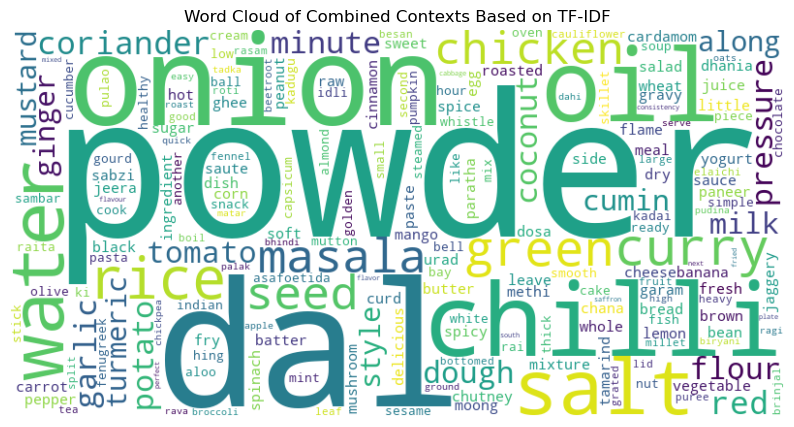

In [17]:
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(recom_df['combined_context'])

# Get the feature names (words) and their corresponding TF-IDF scores
feature_names = vectorizer.get_feature_names_out()
tfidf_scores = tfidf_matrix.sum(axis=0).A1  # Sum TF-IDF scores across all documents (dish names)

# Create a dictionary of words and their TF-IDF scores
word_tfidf_dict = dict(zip(feature_names, tfidf_scores))

wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='viridis')
wordcloud.generate_from_frequencies(word_tfidf_dict)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud of Combined Contexts Based on TF-IDF")
plt.show()

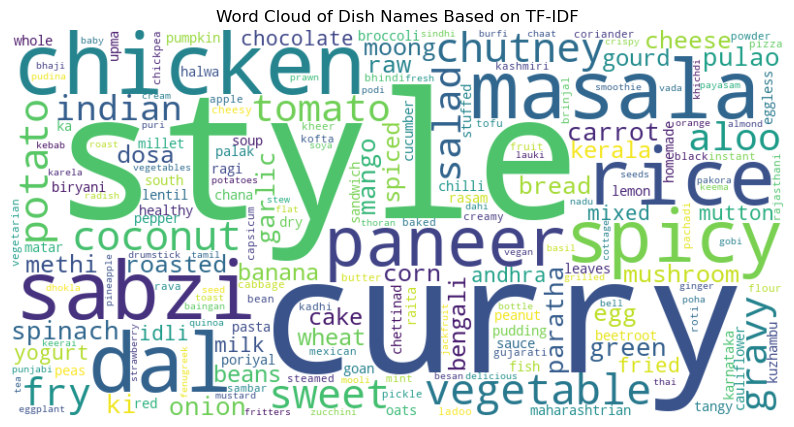

In [18]:
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(recom_df['processed_name'])

# Get the feature names (words) and their corresponding TF-IDF scores
feature_names = vectorizer.get_feature_names_out()
tfidf_scores = tfidf_matrix.sum(axis=0).A1  # Sum TF-IDF scores across all documents (dish names)

# Create a dictionary of words and their TF-IDF scores
word_tfidf_dict = dict(zip(feature_names, tfidf_scores))

wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='viridis')
wordcloud.generate_from_frequencies(word_tfidf_dict)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud of Dish Names Based on TF-IDF")
plt.show()


Train the recommendation model 

In [36]:
tfidf_vectorizer = TfidfVectorizer()

tfidf_combined_matrix = tfidf_vectorizer.fit_transform(recom_df['combined_context'])


# Define number of topics (adjust based on experimentation)
n_topics = 6

nmf_model = NMF(n_components=n_topics, random_state=42)
topic_matrix = nmf_model.fit_transform(tfidf_combined_matrix) # Topic distribution for each recipe

# Add topic distributions to recom_df
for i in range(n_topics):
    recom_df[f'topic_{i}'] = topic_matrix[:, i]

def get_recommendations(dish_name, df, num_recommendations=5):
    # Find the index of the given dish name
    recipe_index = df[df['processed_name'].str.contains(dish_name, case=False, na=False)].index
    if not recipe_index.any():
        print("Dish not found.")
        return None
    
    recipe_index = recipe_index[0]  # Get the first match if there are multiple
    
    # Calculate cosine similarity for the topics
    cosine_similarities = cosine_similarity(topic_matrix )
    similar_indices = cosine_similarities[recipe_index].argsort()[-num_recommendations-1:-1][::-1]
    
    # Get the recommended recipes
    recommended_recipes = df.iloc[similar_indices]
    return recommended_recipes[['name', 'cleaned_ingredients', 'cuisine', 'course', 'diet', 'allergens', 'prep_time']]

In [37]:
# Define a function to filter based on user preferences
def filter_recipes(df, cuisine=None, course=None, diet=None, prep_time=None, allergen_type=None):
    filtered_df = df
    if cuisine:
        filtered_df = filtered_df[filtered_df['cuisine'] == cuisine]
    if course:
        filtered_df = filtered_df[filtered_df['course'] == course]
    if diet:
        filtered_df = filtered_df[filtered_df['diet'] == diet]
    if prep_time:
        filtered_df = filtered_df[filtered_df['categorized_prep_time'] == prep_time]
    if allergen_type:
        # Exclude recipes with allergens in user preference
        filtered_df = filtered_df[~filtered_df['allergen_type'].apply(lambda x: bool(set(x) & set(allergen_type)))]
    return filtered_df

In [38]:
# Example 
recommended_recipes = get_recommendations("jalebi", recom_df)  
if recommended_recipes is not None:
    filtered_recommendations = filter_recipes(recommended_recipes, diet = "Vegetarian")
    print(filtered_recommendations)

                                    name  \
5304  How to Make Homemade Jalebi Recipe   
9412      Patishapta Recipe (Rice Crepe)   
7724   Nei Appam Recipe Using Rice Flour   
3376      Patishapta Recipe (Rice Crepe)   

                                    cleaned_ingredients       cuisine  \
5304  [purpose flour maida, corn flour, curd dahi yo...  North Indian   
9412  [purpose flour maida, semolina rava, rice flou...       Bengali   
7724  [rice flour, jaggery, water, cardamom elaichi ...        Kerala   
3376  [purpose flour maida, semolina rava, rice flou...       Bengali   

       course        diet                allergens  prep_time  
5304  Dessert  Vegetarian  [butter, yogurt, cream]      540.0  
9412  Dessert  Vegetarian           [milk, cashew]       35.0  
7724    Snack  Vegetarian                  unknown      150.0  
3376  Dessert  Vegetarian           [milk, cashew]       35.0  
